In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import cv2
from PIL import Image
import random
import math
from datetime import datetime

In [2]:
start = datetime.now()
print(start)

2025-05-30 02:07:06.929896


# Import Image

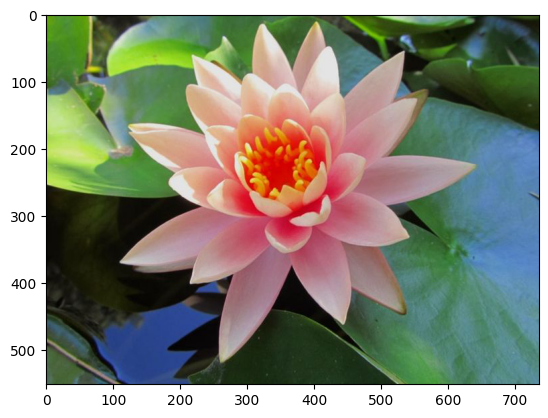

In [3]:
image_path = "./Images/flower.jpg"
original_image = Image.open(image_path).convert("RGB")
plt.imshow(original_image)

# Resize Image

In [4]:
from skimage.transform import resize

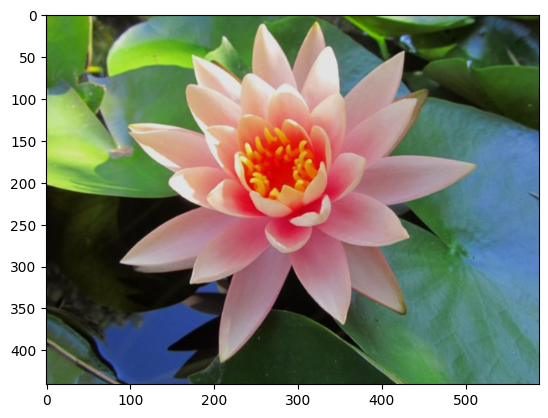

In [5]:
original_image_np = np.array(original_image)

RESIZE_FACTOR = 0.8

original_x_dim, original_y_dim, _ = original_image_np.shape
new_x_dim = int(original_x_dim * RESIZE_FACTOR)
new_y_dim = int(original_y_dim * RESIZE_FACTOR)
new_shape = (new_x_dim, new_y_dim)

downsampled_image = resize(
    original_image_np,
    output_shape=new_shape, 
    preserve_range=True,
    anti_aliasing=True
).astype(np.uint8)

plt.imshow(downsampled_image)

# Grayscale Image

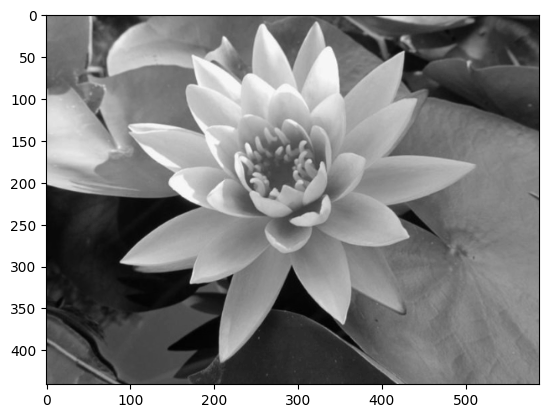

In [6]:
gray_image = cv2.cvtColor(downsampled_image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image, cmap="gray")

# Blur Image

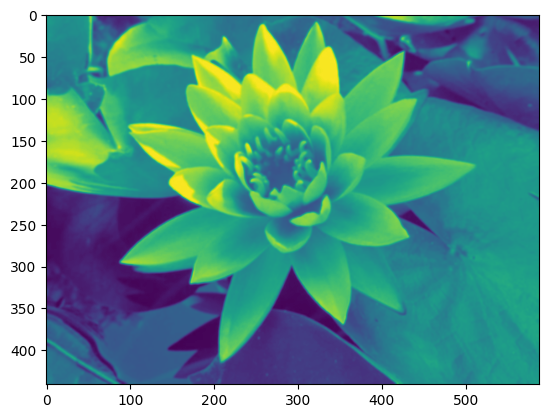

In [7]:
gray_image_np = np.array(gray_image)

BLUR_KERNEL_SIZE = 3
BLUR_SIGMA = 1.4

blurred_image = cv2.GaussianBlur(
    gray_image_np, 
    (BLUR_KERNEL_SIZE, BLUR_KERNEL_SIZE),
    sigmaX=BLUR_SIGMA
)

plt.imshow(blurred_image)

# Canny Filter

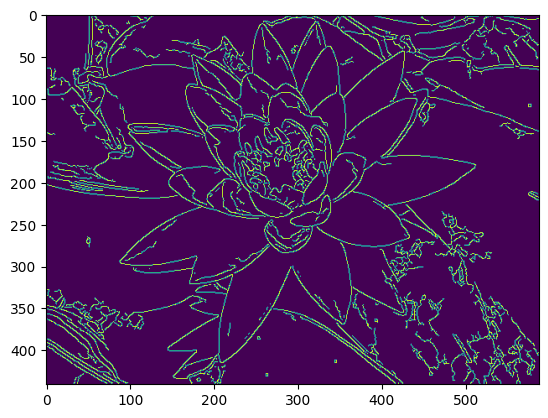

In [8]:
CANNY_THRESHOLD_1 = 50
CANNY_THRESHOLD_2 = 10


canny_edges = cv2.Canny(
    blurred_image, 
    CANNY_THRESHOLD_1,
    CANNY_THRESHOLD_2
)

plt.imshow(canny_edges)

# Detect Contours (and map to colors)

Found 304 countour segments


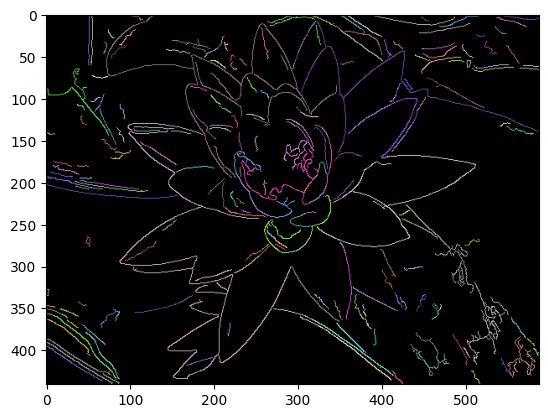

In [9]:
MAX_SEGMENT_ANGLE = np.deg2rad(40)
MIN_SEGMENT_LENGTH = 20
SEGMENT_ANGLE_WINDOW = 10

contours, _ = cv2.findContours(
    canny_edges.copy(),
    cv2.RETR_LIST,
    cv2.CHAIN_APPROX_NONE
)
        
contour_image = np.zeros((*canny_edges.shape, 3), dtype=np.uint8)
contour_id = 0
colors_used = []

for contour in contours: 
    
    points = contour.squeeze()
    if points.ndim != 2 or len(points) < 3:
        continue
        
    breaks = []
    window = SEGMENT_ANGLE_WINDOW
    for i in range(window, len(points) - window):
        segment1 = points[i-window:i]
        segment2 = points[i:i+window]
        
        v1 = segment1[-1] - segment1[0] # vector from behind
        v2 = segment2[-1] - segment2[0] # vector to beyond
        
        n1 = v1 / (np.linalg.norm(v1) + 1e-8)
        n2 = v2 / (np.linalg.norm(v2) + 1e-8)
        
        cosine_similarity = np.dot(n1, n2).clip(-1, 1)
        angle = np.arccos(np.abs(cosine_similarity))
        
        if angle > MAX_SEGMENT_ANGLE:
            breaks.append(i)
    
    ## split the contour 
    split_idxs = np.concatenate([[0], np.array(breaks, dtype=np.uint8), [len(points)]])
    for i in range(len(split_idxs) - 1):
        a, b, = split_idxs[i], split_idxs[i+1]
        segment = points[a:b]
        if (len(segment) < MIN_SEGMENT_LENGTH):
            continue
            
        while True:
            new_color = [random.randint(64, 255) for c in range(3)]
            if new_color not in colors_used:
                colors_used.append(new_color)
                break
                
        for x, y in segment:
            contour_image[y, x] = new_color
            
        contour_id += 1
                
                
print(f"Found {contour_id} countour segments")

plt.imshow(contour_image)
                    
        
        

# Find PCA Length (and rank countours)

In [10]:
from sklearn.decomposition import PCA
from collections import defaultdict

Kept 155 contours after PCA filter


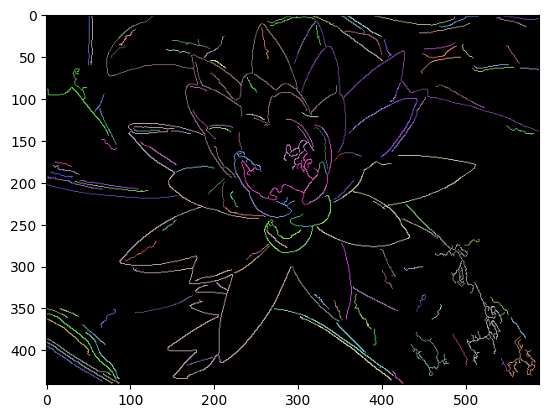

In [11]:
MIN_PCA_DISTANCE = 10

def pca_length(points):
    if len(points) < 2:
        return 0
    pca = PCA(n_components=1)
    projected = pca.fit_transform(points)
    return projected.max()

## map from each contour (key color) to its pixles
color_to_pixels = defaultdict(list)

h, w, c = contour_image.shape
for y in range(h):
    for x in range(w):
        color = tuple(contour_image[y, x])
        if color != (0, 0, 0):
            color_to_pixels[color].append([x, y])
            
## compute PCA length for all contours
color_lengths = []
for color, pixels in color_to_pixels.items():
    points = np.array(pixels)
    length = pca_length(points)
    color_lengths.append((color, length))
    
color_lengths.sort(key = lambda x: x[1], reverse=True)
color_lengths = [(k, v) for k, v in color_lengths if v > MIN_PCA_DISTANCE]

filtered_contour_image = np.zeros((contour_image.shape), dtype=np.uint8)
for color, length in color_lengths: 

    pixels = color_to_pixels[color]
    for x, y in pixels:
    
        filtered_contour_image[y, x] = color
        
print(f"Kept {len(color_lengths)} contours after PCA filter")
        
plt.imshow(filtered_contour_image)

# Select One Contour

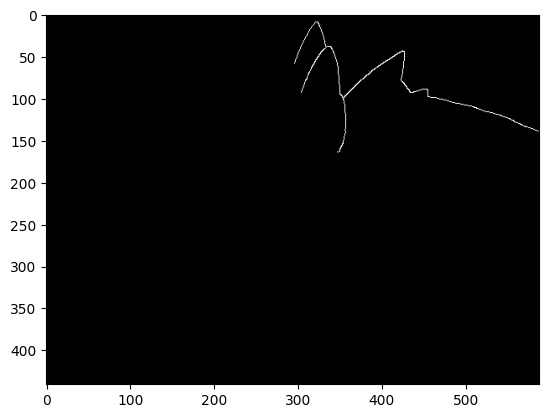

In [12]:
k = 0
color = color_lengths[k][0]

edge_pixels = color_to_pixels[color]

selected_contour_image = np.zeros_like(contour_image)

for x, y in edge_pixels: 
    selected_contour_image[y, x] = [255, 255, 255]
    
plt.imshow(selected_contour_image)

# Draw Squares

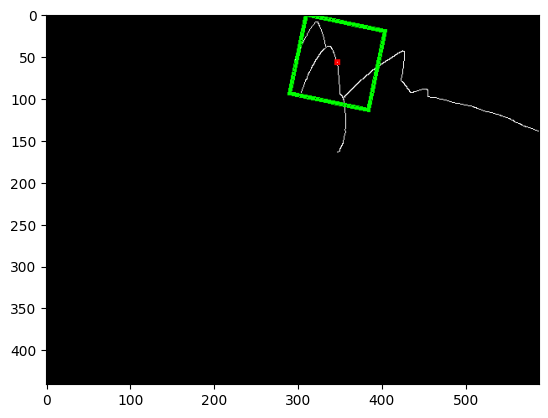

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random

def draw_square(image, center, size, color, border, theta=0):
    x0, y0 = center
    H, W, C = image.shape
    half = size // 2
    angle_rad = np.deg2rad(theta)

    border = min(border, half)

    coords = []
    for dy in range(-half, half + 1):
        for dx in range(-half, half + 1):
            
            ## only work with pixels in border
            if (abs(dy) >= half - border + 1) or (abs(dx) >= half - border + 1):
                
                ## rotate about center
                dy_rot = dy * np.cos(angle_rad) - dx * np.sin(angle_rad)
                dx_rot = dy * np.sin(angle_rad) + dx * np.cos(angle_rad)

                y = int(round(y0 + dy_rot))
                x = int(round(x0 + dx_rot))

                if 0 <= y < H and 0 <= x < W:
                    coords.append((y, x))

    for y, x in coords:
        image[y, x] = color


random_point = random.choice(edge_pixels)
canvas_image = selected_contour_image.copy()

draw_square(
    image=canvas_image,
    center=random_point,
    size=7,
    color=[255, 0, 0],
    border=3
)

draw_square(
    image=canvas_image,
    center=random_point,
    size=100,
    color=[0, 255, 0],
    border=5,
    theta=random.randint(10, 90)
)

plt.imshow(canvas_image)
plt.show()


# Define Reward Function + Align Theta

In [14]:
def reward_function(image, center, size, theta, decay_rate=2.0):
    """
    Compute a reward that reflects how well a rotated square's centerline
    aligns with bright (edge) pixels in the image.
    """
    
#     print("Example pixel:", image[int(center[0]), int(center[1])])
#     print("Max pixel in image:", np.max(image))
#     print("Image dtype:", image.dtype)
    
    x0, y0 = center
    H, W = image.shape
    half = size / 2
    angle_rad = np.deg2rad(theta)
    reward = 0.0
    


    for dx in range(-size//2, size//2 + 1):
        dy = 0
        dy_rot = dy * np.cos(angle_rad) - dx * np.sin(angle_rad)
        dx_rot = dy * np.sin(angle_rad) + dx * np.cos(angle_rad)

        y = int(round(y0 + dy_rot))
        x = int(round(x0 + dx_rot))

        if 0 <= y < H and 0 <= x < W:
            base_intensity = image[y, x]
            reward += base_intensity

            for offset in range(1, 6):
                # Above centerline
                dy_off = offset
                dy_rot = dy_off * np.cos(angle_rad) - dx * np.sin(angle_rad)
                dx_rot = dy_off * np.sin(angle_rad) + dx * np.cos(angle_rad)
                y_off = int(round(y0 + dy_rot))
                x_off = int(round(x0 + dx_rot))
                if 0 <= y_off < H and 0 <= x_off < W:
                    weight = np.exp(-decay_rate * (offset / half) ** 2)
                    reward += weight * image[y_off, x_off]

                # Below centerline
                dy_off = -offset
                dy_rot = dy_off * np.cos(angle_rad) - dx * np.sin(angle_rad)
                dx_rot = dy_off * np.sin(angle_rad) + dx * np.cos(angle_rad)
                y_off = int(round(y0 + dy_rot))
                x_off = int(round(x0 + dx_rot))
                if 0 <= y_off < H and 0 <= x_off < W:
                    weight = np.exp(-decay_rate * (offset / half) ** 2)
                    reward += weight * image[y_off, x_off]



    return reward


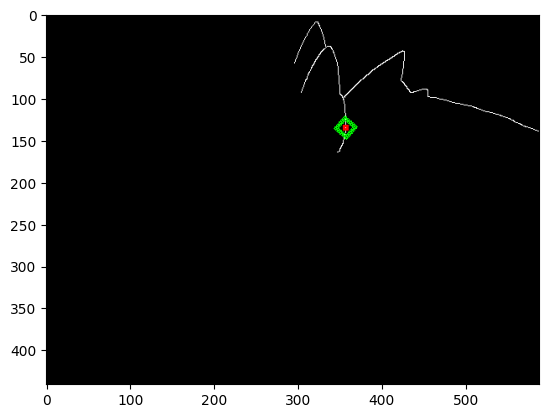

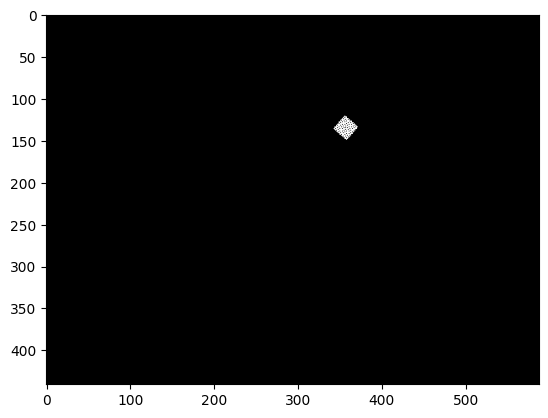

In [15]:
ERROR_CODE_NO_VALID_THETA = -999  # special negative int

def get_square_coords(center, size, border, theta, image_shape):
    """Get all coordinates of the square border with rotation."""
    y0, x0 = center
    H, W = image_shape
    angle_rad = np.deg2rad(theta)
    coords = []

    for dy in range(-size//2, size//2 + 1):
        for dx in range(-size//2, size//2 + 1):
            if (abs(dy) >= size//2 - border + 1) or (abs(dx) >= size//2 - border + 1):
                dy_rot = dy * np.cos(angle_rad) - dx * np.sin(angle_rad)
                dx_rot = dy * np.sin(angle_rad) + dx * np.cos(angle_rad)

                y = int(round(y0 + dy_rot))
                x = int(round(x0 + dx_rot))

                if 0 <= y < H and 0 <= x < W:
                    coords.append((y, x))
    return coords

def is_valid_square(mask, center, size, border, theta):
    """Check if the square with given params would overlap with the mask."""
    coords = get_square_coords(center, size, border, theta, mask.shape)
    return all(mask[y, x] == 0 for y, x in coords)

def find_best_theta(image, center, size, mask, theta_range=(-45, 45), decay_rate=2.0):
    
    image = np.mean(image[...,:3], axis=-1)
    mask = np.mean(mask[...,:3], axis=-1)
    
    best_theta = None
    best_reward = -float('inf')
    border = 5  # assumed from your draw_square usage

    for theta in range(theta_range[0], theta_range[1] + 1):
        if is_valid_square(mask, center, size, border, theta):
            reward = reward_function(image, center, size, theta, decay_rate)
#             print("Theta: ", theta, "Reward: ", reward)
            if reward > best_reward:
                best_reward = reward
                best_theta = theta

    return best_theta if best_theta is not None else ERROR_CODE_NO_VALID_THETA

        
        
canvas_image = selected_contour_image.copy()
mask = np.zeros_like(selected_contour_image, dtype=np.uint8)

SIZE = 20
DECAY_RATE = 2

# Pick a random point on the edge
random_point = random.choice(edge_pixels)


best_theta = find_best_theta(selected_contour_image, random_point, SIZE, mask, decay_rate=DECAY_RATE)


if best_theta != ERROR_CODE_NO_VALID_THETA:


    ## show starting point
    draw_square(
        image=canvas_image,
        center=random_point,
        size=7,
        color=[255, 0, 0],
        border=5
    )

    ## show tile
    draw_square(
        image=canvas_image,
        center=random_point,
        size=SIZE,
        color=[0, 255, 0],
        border=5,
        theta=best_theta
    )


    ## add tile to mask
    draw_square(
        image=mask,
        center=random_point,
        size=SIZE,
        color=[255, 255, 255],
        border=SIZE//2 + 1,
        theta=best_theta

    )


    # Show result
    plt.figure()
    plt.imshow(canvas_image)
    plt.show()


    plt.figure()
    plt.imshow(mask)
    plt.show()
    



# Find Next Points

Found 3 intersecting edge points.


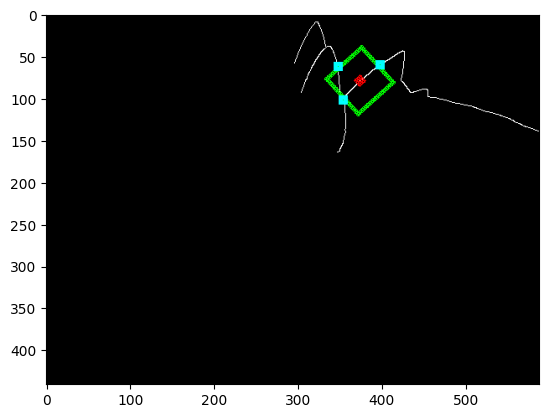

In [16]:
import numpy as np

# Function to calculate the Euclidean distance between two points
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Function to filter the points based on the distance criterion
def filter_points(points, d):
    if len(points) == 0: 
        return []
    selected_points = [points[0]]  # Keep the first point
    for point in points[1:]:
        # Check if the point is at least `d` distance away from all selected points
        if all(euclidean_distance(point, selected_point) >= d for selected_point in selected_points):
            selected_points.append(point)
    return selected_points

def get_rotated_square_border(center, size, theta_deg, step=1):
    """Return coordinates of border pixels for a rotated square."""
    x0, y0 = center
    half = size // 2
    angle_rad = np.deg2rad(theta_deg)
    coords = []

    # Define unrotated corners of the square
    corners = [
        (-half, -half),
        (-half,  half),
        ( half,  half),
        ( half, -half)
    ]

    # Trace the 4 sides between corners
    for i in range(4):
        y1, x1 = corners[i]
        y2, x2 = corners[(i + 1) % 4]
        dist = max(abs(x2 - x1), abs(y2 - y1))
        for t in np.linspace(0, 1, int(dist / step) + 1):
            dy = y1 + t * (y2 - y1)
            dx = x1 + t * (x2 - x1)
            # Rotate
            dy_rot = dy * np.cos(angle_rad) - dx * np.sin(angle_rad)
            dx_rot = dy * np.sin(angle_rad) + dx * np.cos(angle_rad)
            # Translate to image coords
            y = int(round(y0 + dy_rot))
            x = int(round(x0 + dx_rot))
            coords.append((y, x))

    return list(set(coords))  # Remove duplicates


def get_edge_intersections(edge_image, center, size, theta_deg, step=1, threshold=128):
    """
    Return a list of edge pixels that intersect with a concentric square 
    of double the size and given rotation.
    """
    # Convert image to grayscale if it's RGB
    if edge_image.ndim == 3:
        edge_image = np.mean(edge_image[..., :3], axis=-1)

    H, W = edge_image.shape
    border_coords = get_rotated_square_border(center, size, theta_deg, step)

    valid_points = []
    for y, x in border_coords:
        if 0 <= y < H and 0 <= x < W and edge_image[y, x] >= threshold:
            valid_points.append((x, y))

            
    filtered_points = filter_points(valid_points, d=int(size//10))
    
    return filtered_points


SIZE = 20

random_point = random.choice(edge_pixels)
best_theta = find_best_theta(selected_contour_image, random_point, SIZE, mask, decay_rate=DECAY_RATE)


search_square_size = int(3*SIZE)

intersections = get_edge_intersections(
    edge_image=selected_contour_image, 
    center=random_point, 
    size=search_square_size, 
    theta_deg=best_theta
)


canvas_image_2 = selected_contour_image.copy()


draw_square(
    image=canvas_image_2,
    center=random_point,
    size=10,
    color=[255, 0, 0],
    border=5,
    theta=best_theta
)

draw_square(
        image=canvas_image_2,
        center=random_point,
        size=search_square_size,
        color=[0, 255, 0],
        border=5,
        theta=best_theta
)

for point in intersections:
    draw_square(
        image=canvas_image_2,
        center=point,
        size=10,
        color=[0, 255, 255],
        border=5,
        theta=0
    )


print(f"Found {len(intersections)} intersecting edge points.")


plt.imshow(canvas_image_2)

# Perform multiple searches

Found 4 intersecting edge points.
Found 3 intersecting edge points.
Found 1 intersecting edge points.


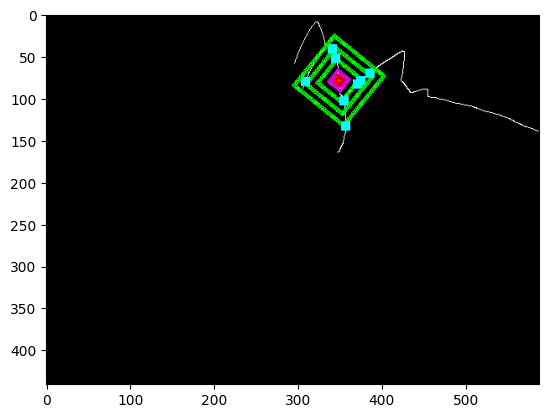

In [17]:
SIZE = 20

INITIAL_RADIUS = 20
SEARCH_ITERATIONS = 3

search_square_sizes = [SIZE + INITIAL_RADIUS * i for i in range(1,SEARCH_ITERATIONS+1)]
search_square_sizes

random_point = random.choice(edge_pixels)
best_theta = find_best_theta(selected_contour_image, random_point, SIZE, mask, decay_rate=DECAY_RATE)



canvas_image_2 = selected_contour_image.copy()

## draw original square
draw_square(
        image=canvas_image_2,
        center=random_point,
        size=SIZE,
        color=[255, 0, 255],
        border=5,
        theta=best_theta
)

for search_square_size in search_square_sizes:

    intersections = get_edge_intersections(
        edge_image=selected_contour_image, 
        center=random_point, 
        size=search_square_size, 
        theta_deg=best_theta
    )


    

    ## draw center (dot shaped)
    draw_square(
        image=canvas_image_2,
        center=random_point,
        size=10,
        color=[255, 0, 0],
        border=5,
        theta=best_theta
    )

    ## draw search square
    draw_square(
            image=canvas_image_2,
            center=random_point,
            size=search_square_size,
            color=[0, 255, 0],
            border=5,
            theta=best_theta
    )


    for point in intersections:
        draw_square(
            image=canvas_image_2,
            center=point,
            size=10,
            color=[0, 255, 255],
            border=5,
            theta=0
        )


    print(f"Found {len(intersections)} intersecting edge points.")


plt.imshow(canvas_image_2)

# Complete One BFS Frontier

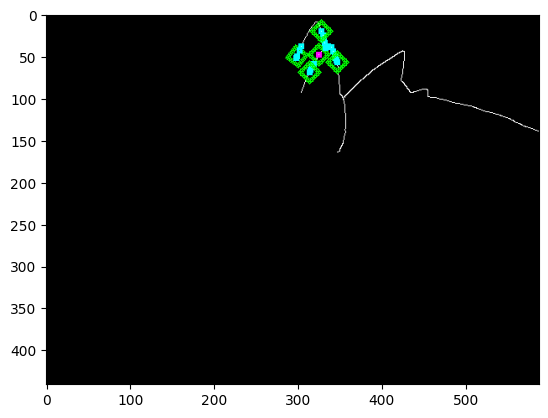

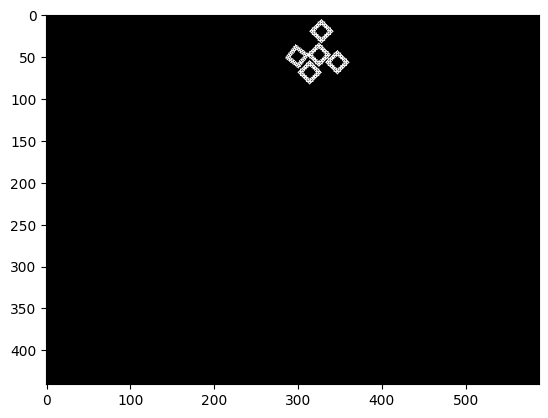

In [18]:
import numpy as np
import matplotlib.pyplot as plt

ERROR_CODE_NO_VALID_THETA = -999  # special negative int

def draw_square(image, center, size, color, border, theta=0):
    """Draws a rotated square border on a 3-channel image."""
    x0, y0 = center
    H, W, C = image.shape
    half = size // 2
    angle_rad = np.deg2rad(theta)
    border = min(border, half)

    coords = []
    for dy in range(-half, half + 1):
        for dx in range(-half, half + 1):
            if (abs(dy) >= half - border + 1) or (abs(dx) >= half - border + 1):
                dy_rot = dy * np.cos(angle_rad) - dx * np.sin(angle_rad)
                dx_rot = dy * np.sin(angle_rad) + dx * np.cos(angle_rad)

                y = int(round(y0 + dy_rot))
                x = int(round(x0 + dx_rot))

                if 0 <= y < H and 0 <= x < W:
                    coords.append((y, x))

    for y, x in coords:
        image[y, x] = color

def draw_mask(mask, center, size, border, theta=0):
    """Updates a 2D mask with 1s where the square would be drawn."""
    coords = get_square_coords(center, size, border, theta, mask.shape)
    for y, x in coords:
        mask[y, x] = 1
        
def place_tile(image, mask_draw, mask_check, center, size, border, theta=0):
    # draw tile (green)
    draw_square(
        image=image,
        center=center,
        size=size,
        color=[0, 255, 0],
        border=border,
        theta=theta
    )

    # draw on visualization mask (white)
    draw_square(
        image=mask_draw,
        center=center,
        size=SIZE,
        color=[255, 255, 255],
        border=border,
        theta=theta
    )

    # update logical mask
    draw_mask(
        mask=mask_check,
        center=center,
        size=size,
        border=border,
        theta=theta
    )
    

def get_square_coords(center, size, border, theta, image_shape):
    """Returns list of rotated square border coordinates within image bounds."""
    y0, x0 = center
    H, W = image_shape
    angle_rad = np.deg2rad(theta)
    coords = []

    for dy in range(-size // 2, size // 2 + 1):
        for dx in range(-size // 2, size // 2 + 1):
            if (abs(dy) >= size // 2 - border + 1) or (abs(dx) >= size // 2 - border + 1):
                dy_rot = dy * np.cos(angle_rad) - dx * np.sin(angle_rad)
                dx_rot = dy * np.sin(angle_rad) + dx * np.cos(angle_rad)

                y = int(round(y0 + dy_rot))
                x = int(round(x0 + dx_rot))

                if 0 <= y < H and 0 <= x < W:
                    coords.append((y, x))
    return coords

def is_valid_square(mask_check, center, size, border, theta):
    """Checks if a square's border would overlap anything already on the mask."""
    coords = get_square_coords(center, size, border, theta, mask_check.shape)
    return all(mask_check[y, x] == 0 for y, x in coords)

def reward_function(image, center, size, theta, decay_rate):
    """
    Dummy reward function. Replace this with your actual logic.
    Here, we just reward based on brightness of the square.
    """
    coords = get_square_coords(center, size, border=5, theta=theta, image_shape=image.shape)
    values = [image[y, x] for y, x in coords]
    return np.sum(values) / (len(values) + 1e-5)

def find_best_theta(image, center, size, mask_check, theta_range=(-45, 45), decay_rate=2.0):
    """Searches for the best rotation angle for a tile at the given center."""
    grayscale = np.mean(image[..., :3], axis=-1)

    best_theta = None
    best_reward = -float('inf')
    border = 5

    for theta in range(theta_range[0], theta_range[1] + 1):
        if is_valid_square(mask_check, center, size, border, theta):
            reward = reward_function(grayscale, center, size, theta, decay_rate)
            if reward > best_reward:
                best_reward = reward
                best_theta = theta

    return best_theta if best_theta is not None else ERROR_CODE_NO_VALID_THETA


canvas_image = selected_contour_image.copy()
mask_draw = np.zeros_like(selected_contour_image, dtype=np.uint8)  # for visualization
mask_check = np.zeros(selected_contour_image.shape[:2], dtype=np.uint8)  # for overlap checking

SIZE = 20
BORDER = 5
DECAY_RATE = 2

INITIAL_RADIUS = 5
SEARCH_ITERATIONS = 5

search_square_sizes = [SIZE + INITIAL_RADIUS * i for i in range(1,SEARCH_ITERATIONS+1)]


random_point = random.choice(edge_pixels)
best_theta = find_best_theta(selected_contour_image, random_point, SIZE, mask_check, decay_rate=DECAY_RATE)




intersections_list = []

for search_square_size in search_square_sizes:

    intersections = get_edge_intersections(
        edge_image=selected_contour_image, 
        center=random_point, 
        size=search_square_size, 
        theta_deg=best_theta
    )

    
    intersections_list.extend(intersections)










# show random point (small pink dot)
draw_square(
    image=canvas_image,
    center=random_point,
    size=7,
    color=[255, 0, 255],
    border=3
)


place_tile(canvas_image, mask_draw, mask_check, random_point, SIZE, BORDER, best_theta)





for point in intersections_list: 
    
    # show starting point (small red dot)
    draw_square(
        image=canvas_image,
        center=point,
        size=7,
        color=[0, 255, 255],
        border=3
    )

    
    best_theta = find_best_theta(selected_contour_image, point, SIZE, mask_check, decay_rate=DECAY_RATE)

    if best_theta != ERROR_CODE_NO_VALID_THETA:
        
        place_tile(canvas_image, mask_draw, mask_check, point, SIZE, BORDER, best_theta)


plt.figure()
plt.imshow(canvas_image)
plt.show()

plt.figure()
plt.imshow(mask_draw)
plt.show()


# Full BFS

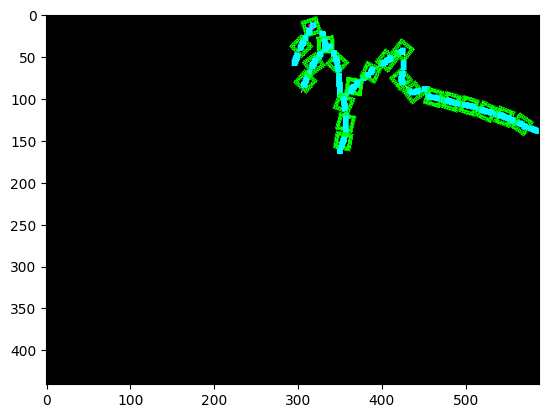

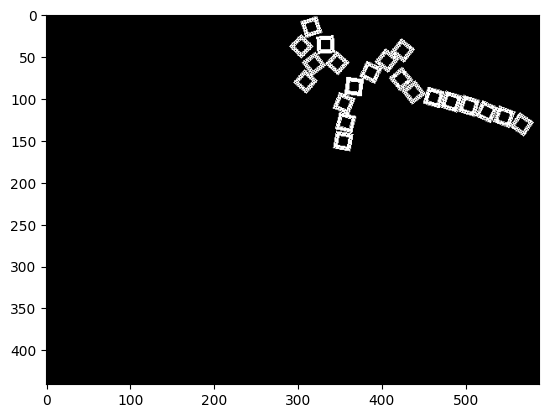

In [19]:
from collections import deque


ERROR_CODE_NO_VALID_THETA = -999  # special negative int

def draw_square(image, center, size, color, border, theta=0):
    """Draws a rotated square border on a 3-channel image."""
    x0, y0 = center
    H, W, C = image.shape
    half = size // 2
    angle_rad = np.deg2rad(theta)
    border = min(border, half)

    coords = []
    for dy in range(-half, half + 1):
        for dx in range(-half, half + 1):
            if (abs(dy) >= half - border + 1) or (abs(dx) >= half - border + 1):
                dy_rot = dy * np.cos(angle_rad) - dx * np.sin(angle_rad)
                dx_rot = dy * np.sin(angle_rad) + dx * np.cos(angle_rad)

                y = int(round(y0 + dy_rot))
                x = int(round(x0 + dx_rot))

                if 0 <= y < H and 0 <= x < W:
                    coords.append((y, x))

    for y, x in coords:
        image[y, x] = color

def draw_mask(mask, center, size, border, theta=0):
    """Updates a 2D mask with 1s where the square would be drawn."""
    coords = get_square_coords(center, size, border, theta, mask.shape)
    for y, x in coords:
        mask[y, x] = 1
        
def place_tile(image, mask_draw, mask_check, center, size, border, theta=0):
    # draw tile (green)
    draw_square(
        image=image,
        center=center,
        size=size,
        color=[0, 255, 0],
        border=border,
        theta=theta
    )

    # draw on visualization mask (white)
    draw_square(
        image=mask_draw,
        center=center,
        size=SIZE,
        color=[255, 255, 255],
        border=border,
        theta=theta
    )

    # update logical mask
    draw_mask(
        mask=mask_check,
        center=center,
        size=size,
        border=border,
        theta=theta
    )
    

def get_square_coords(center, size, border, theta, image_shape):
    """Returns list of rotated square border coordinates within image bounds."""
    x0, y0 = center
    H, W = image_shape
    angle_rad = np.deg2rad(theta)
    coords = []

    for dy in range(-size // 2, size // 2 + 1):
        for dx in range(-size // 2, size // 2 + 1):
            if (abs(dy) >= size // 2 - border + 1) or (abs(dx) >= size // 2 - border + 1):
                dy_rot = dy * np.cos(angle_rad) - dx * np.sin(angle_rad)
                dx_rot = dy * np.sin(angle_rad) + dx * np.cos(angle_rad)

                y = int(round(y0 + dy_rot))
                x = int(round(x0 + dx_rot))

                if 0 <= y < H and 0 <= x < W:
                    coords.append((y, x))
    return coords

def is_valid_square(mask_check, center, size, border, theta):

    
    
    """Checks if a square's border would overlap anything already on the mask."""
    coords = get_square_coords(center, size, border, theta, mask_check.shape)
    return all(mask_check[y, x] == 0 for y, x in coords)



def check_any_valid_rotation(mask_check, center, size):
    
    H, W = mask_check.shape
    ## adjust for indexing
    H -= 1
    W -= 1
    
    x, y = center
    
    candidate_points = [
        (x + size // 2, y),
        (x - size // 2, y),
        (x, y + size // 2),
        (x, y - size // 2)
    ]
    
    filtered_candidate_points = [(min(W, (max(0, x))), min(H, (max(0, y)))) for x, y in candidate_points]
    for x, y in filtered_candidate_points:
        if mask_check[y, x] != 0:
            return False
    
    
    return True

def find_best_theta(image, center, size, mask_check, theta_range=(-45, 45), decay_rate=2.0):
    """Searches for the best rotation angle for a tile at the given center."""

    ## initial check to spare rotations if possible
    
    if not check_any_valid_rotation(mask_check, center, size):
        return ERROR_CODE_NO_VALID_THETA
    
    

    best_theta = None
    best_reward = -float('inf')
    border = BORDER

    for theta in range(theta_range[0], theta_range[1] + 1):
        if is_valid_square(mask_check, center, size, border, theta):
            reward = reward_function(image, center, size, theta, decay_rate)
            if reward > best_reward:
                best_reward = reward
                best_theta = theta

    return best_theta if best_theta is not None else ERROR_CODE_NO_VALID_THETA







canvas_image = selected_contour_image.copy()
mask_draw = np.zeros_like(selected_contour_image, dtype=np.uint8)  # for visualization
mask_check = np.zeros(selected_contour_image.shape[:2], dtype=np.uint8)  # for overlap checking
gray_image = np.mean(selected_contour_image[..., :3], axis=-1)

SIZE = 20
BORDER = 5
DECAY_RATE = 1.5

SEARCH_RADIUS = 5
SEARCH_ITERATIONS = 7

search_square_sizes = [SIZE + SEARCH_RADIUS * i for i in range(1,SEARCH_ITERATIONS+1)]


## choose global BFS start here
random_point = random.choice(edge_pixels)
# show starting point (small pink dot)
draw_square(
    image=canvas_image,
    center=random_point,
    size=7,
    color=[255, 0, 255],
    border=3
)


## Attempt to place first tile
best_theta = find_best_theta(gray_image, random_point, SIZE, mask_check, decay_rate=DECAY_RATE)
assert(best_theta != ERROR_CODE_NO_VALID_THETA)
place_tile(canvas_image, mask_draw, mask_check, random_point, SIZE, BORDER, best_theta)



H, W, C = canvas_image.shape

q = deque([random_point])
visited = set()
visited.add(tuple(int(x) for x in random_point))

while len(q) > 0:
    
    
    
    # print("Q: ", q)
    
    starting_point = q.popleft()
    
    
    best_theta = find_best_theta(gray_image, starting_point, SIZE, mask_check, decay_rate=DECAY_RATE)

    intersections_list = []

    for search_square_size in search_square_sizes:

        intersections = get_edge_intersections(
            edge_image=selected_contour_image, 
            center=starting_point, 
            size=search_square_size, 
            theta_deg=best_theta
        )


        intersections_list.extend(intersections)




    for point in intersections_list: 
        
        if point in visited:
            continue
            
        point_x, point_y = point
            
        if point_x >= 0 and point_x <= W and point_y >= 0 and point_y <= H:
            if mask_check[point_y, point_x] == 1:
                # print("Intersection inside mask")
                continue
        else: 
            # point out of bounds
            # print("Out of bounds point: ", point)
            continue

        # show intersecting point (small cyan dot)
        draw_square(
            image=canvas_image,
            center=point,
            size=7,
            color=[0, 255, 255],
            border=3
        )


        best_theta = find_best_theta(gray_image, point, SIZE, mask_check, decay_rate=DECAY_RATE)

        if best_theta != ERROR_CODE_NO_VALID_THETA:

            place_tile(canvas_image, mask_draw, mask_check, point, SIZE, BORDER, best_theta)
            q.append(point)
            visited.add(tuple(int(x) for x in point))


plt.figure()
plt.imshow(canvas_image)
plt.show()

plt.figure()
plt.imshow(mask_draw)
plt.show()


# Run Bfs on all contours

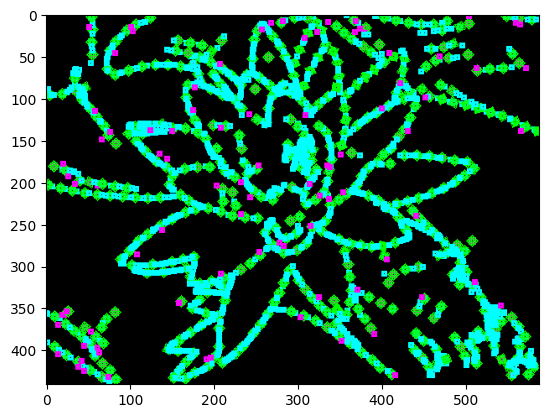

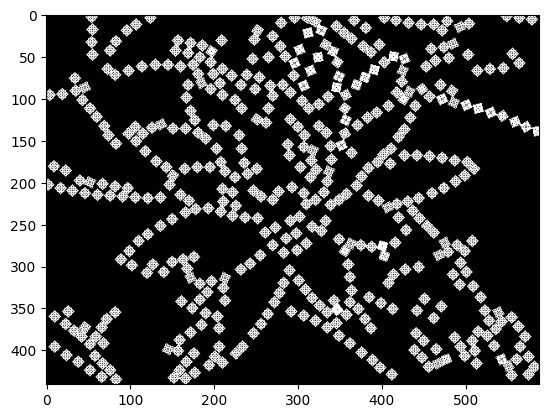

In [20]:
def place_tile(tiles_placed_info, image, mask_draw, mask_check, center, size, border, theta=0):
    
    info = {
                "point": center,
                "rotation": theta,
                "order": len(tiles_placed_info)
            }
    tiles_placed_info.append(info)
    
    
    
    # draw tile (green)
    draw_square(
        image=image,
        center=center,
        size=size,
        color=[0, 255, 0],
        border=border,
        theta=theta
    )

    # draw on visualization mask (white)
    draw_square(
        image=mask_draw,
        center=center,
        size=SIZE,
        color=[255, 255, 255],
        border=border,
        theta=theta
    )

    # update logical mask
    draw_mask(
        mask=mask_check,
        center=center,
        size=size,
        border=border,
        theta=theta
    )



canvas_image = np.zeros_like(contour_image, dtype=np.uint8)
mask_draw = np.zeros_like(contour_image, dtype=np.uint8)  # for visualization
mask_check = np.zeros(contour_image.shape[:2], dtype=np.uint8)  # for overlap checking
gray_image = np.mean(selected_contour_image[..., :3], axis=-1)



SIZE = 10
BORDER = 10
DECAY_RATE = 2

SEARCH_RADIUS = 10
SEARCH_ITERATIONS = 7

search_square_sizes = [SIZE + SEARCH_RADIUS * i for i in range(1,SEARCH_ITERATIONS+1)]

tiles_placed_info = []



for color, length in color_lengths: 

    edge_pixels = color_to_pixels[color]
    
    selected_contour_image = np.zeros_like(contour_image)

    for x, y in edge_pixels: 
        selected_contour_image[y, x] = [255, 255, 255]
        
        
        
        
    ## choose global BFS start here
    random_point = random.choice(edge_pixels)
    # show starting point (small pink dot)
    draw_square(
        image=canvas_image,
        center=random_point,
        size=7,
        color=[255, 0, 255],
        border=3
    )


    ## Attempt to place first tile
    best_theta = find_best_theta(gray_image, random_point, SIZE, mask_check, decay_rate=DECAY_RATE)
    if best_theta == ERROR_CODE_NO_VALID_THETA:
        continue
        
    

        
    place_tile(tiles_placed_info, canvas_image, mask_draw, mask_check, random_point, SIZE, BORDER, best_theta)



    H, W, C = canvas_image.shape

    q = deque([random_point])
    visited = set()
    visited.add(tuple(int(x) for x in random_point))

    while len(q) > 0:



        # print("Q: ", q)

        starting_point = q.popleft()


        best_theta = find_best_theta(gray_image, starting_point, SIZE, mask_check, decay_rate=DECAY_RATE)

        intersections_list = []

        for search_square_size in search_square_sizes:

            intersections = get_edge_intersections(
                edge_image=selected_contour_image, 
                center=starting_point, 
                size=search_square_size, 
                theta_deg=best_theta
            )


            intersections_list.extend(intersections)




        for point in intersections_list: 

            if point in visited:
                continue

            point_x, point_y = point

            if point_x >= 0 and point_x <= W and point_y >= 0 and point_y <= H:
                if mask_check[point_y, point_x] == 1:
                    # print("Intersection inside mask")
                    continue
            else: 
                # point out of bounds
                # print("Out of bounds point: ", point)
                continue

            # show intersecting point (small cyan dot)
            draw_square(
                image=canvas_image,
                center=point,
                size=7,
                color=[0, 255, 255],
                border=3
            )


            best_theta = find_best_theta(gray_image, point, SIZE, mask_check, decay_rate=DECAY_RATE)

            if best_theta != ERROR_CODE_NO_VALID_THETA:
                

                place_tile(tiles_placed_info, canvas_image, mask_draw, mask_check, point, SIZE, BORDER, best_theta)
                q.append(point)
                visited.add(tuple(int(x) for x in point))
                
                
                
                # print("placed tile at point: ", point)
                
            else: 
                222
                #print("wasted time on point: ", point)


plt.figure()
plt.imshow(canvas_image)
plt.show()

plt.figure()
plt.imshow(mask_draw)
plt.show()


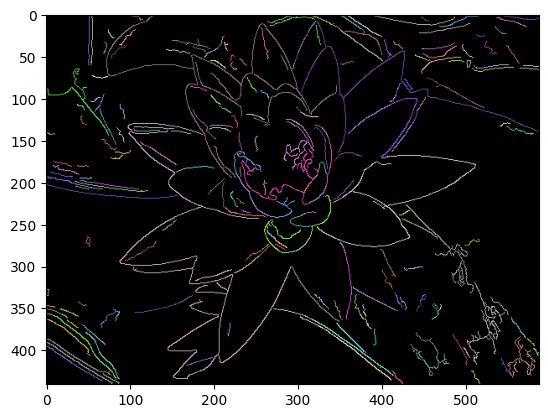

In [21]:
plt.imshow(contour_image)

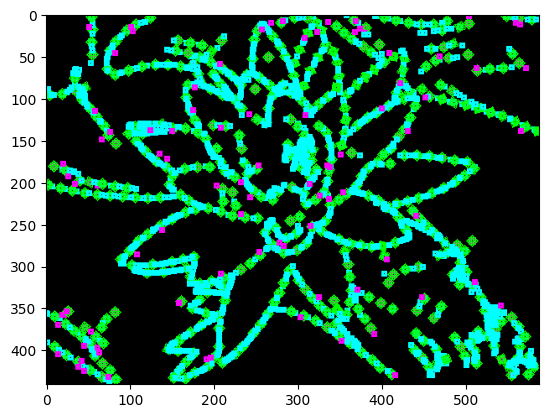

In [22]:
plt.imshow(canvas_image)

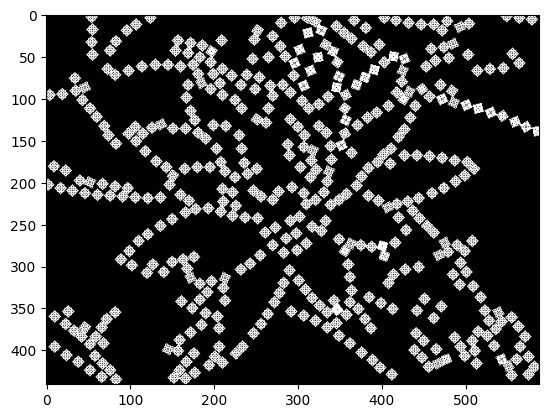

In [23]:
plt.imshow(mask_draw)

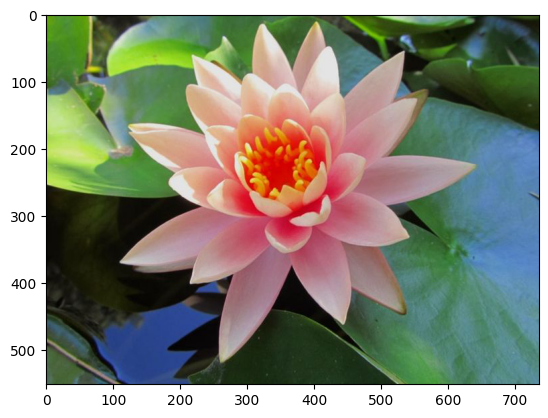

In [24]:
plt.imshow(original_image)

# Reconstruct Image

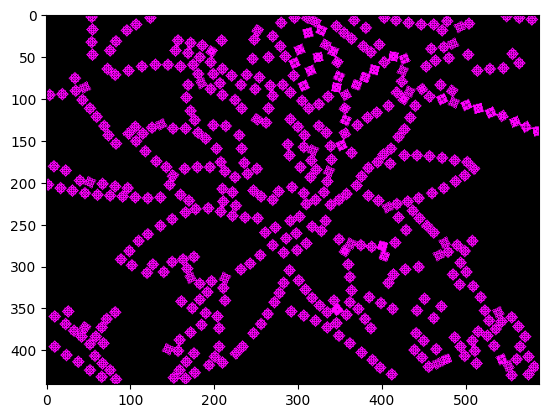

In [25]:
rendered_image = np.zeros_like(mask_draw)

for point_info in tiles_placed_info:
    
    draw_square(
        image=rendered_image,
        center=point_info["point"],
        size=SIZE,
        color=[255, 0, 255],
        border=SIZE//2,
        theta=point_info["rotation"]
    )
    
plt.imshow(rendered_image)

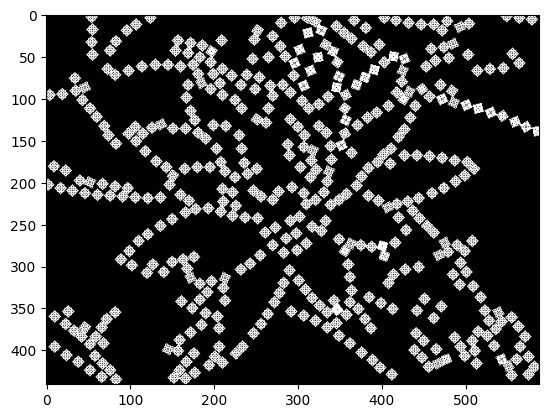

In [26]:
plt.imshow(mask_draw)

# Compute Voronoi Map

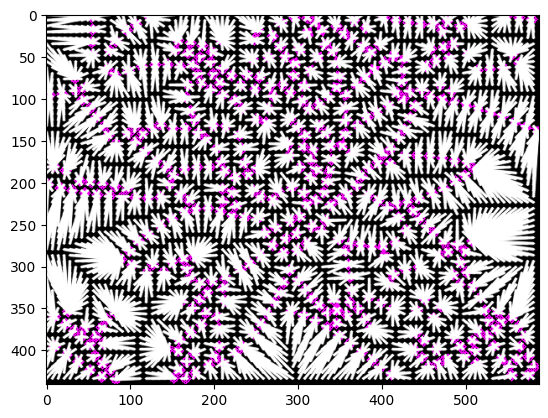

In [27]:
from scipy.spatial import cKDTree

placed_tile_coords = [tile["point"] for tile in tiles_placed_info]
tree = cKDTree(placed_tile_coords)

GRID_SIZE = 7
sample_points = []
for y in range(0, H, GRID_SIZE):
    for x in range(0, W, GRID_SIZE):
        sample_points.append((x, y))
        
distances, indicies = tree.query(sample_points)
        

    
voronoi_image = rendered_image.copy()

closest_tile_coords = [placed_tile_coords[index] for index in indicies]
for sample_point, closest_tile_point in zip(sample_points, closest_tile_coords):
    cv2.line(
        voronoi_image, 
        sample_point, 
        closest_tile_point,
        color=(255, 255, 255),
        thickness=2,
        lineType=cv2.LINE_AA
    )

plt.imshow(voronoi_image)

# Find Candidate Fill Points

In [28]:
placed_tile_rotations = [tile["rotation"] for tile in tiles_placed_info]

closest_tile_rotations = [placed_tile_rotations[index] for index in indicies]



candidate_points_info = []


for i in range(len(distances)):
    
  
    
    point_info = {
        "point": sample_points[i],
        
        "rotation": placed_tile_rotations[indicies[i]],
        "distance": distances[i]
    }
    candidate_points_info.append(point_info)
    
candidate_points_info.sort(key = lambda x: x["distance"])

candidate_points_info[:10]
    

[{'point': (35, 91), 'rotation': -45, 'distance': 0.0},
 {'point': (336, 98), 'rotation': -45, 'distance': 0.0},
 {'point': (357, 126), 'rotation': -27, 'distance': 0.0},
 {'point': (427, 168), 'rotation': -45, 'distance': 0.0},
 {'point': (147, 203), 'rotation': -45, 'distance': 0.0},
 {'point': (91, 217), 'rotation': -45, 'distance': 0.0},
 {'point': (364, 329), 'rotation': -45, 'distance': 0.0},
 {'point': (364, 28), 'rotation': -45, 'distance': 1.0},
 {'point': (154, 42), 'rotation': -45, 'distance': 1.0},
 {'point': (301, 42), 'rotation': 24, 'distance': 1.0}]

# Place Fill Tiles

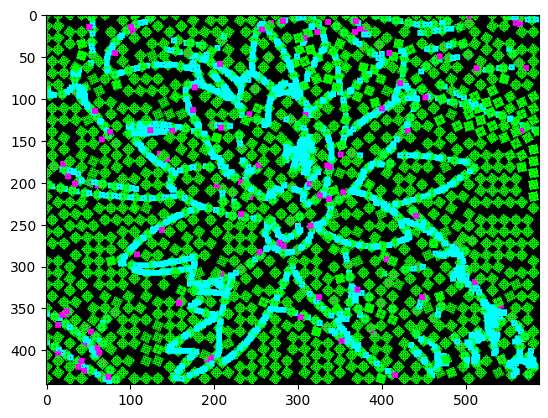

In [29]:
ERROR_CODE_NO_VALID_THETA = -999  # special negative int

def reward_function_fill(theta, original_theta):
    # Reward is negative absolute angle difference — higher reward if angles are more aligned
    diff = abs(theta - original_theta) % 180
    return -min(diff, 180 - diff)  # e.g., 10 deg diff → -10; 170 deg diff → -10

def find_best_theta_fill(center, size, mask_check, original_theta, theta_range=(-45, 45)):
    
    if not check_any_valid_rotation(mask_check, center, size):
        return ERROR_CODE_NO_VALID_THETA
    
    best_theta = None
    best_reward = -float('inf')
    border = BORDER

    for theta in range(theta_range[0], theta_range[1] + 1):
        if is_valid_square(mask_check, center, size, border, theta):
            reward = reward_function_fill(theta, original_theta)
            if reward > best_reward:
                best_reward = reward
                best_theta = theta

    return best_theta if best_theta is not None else ERROR_CODE_NO_VALID_THETA



voronoi_canvas = canvas_image.copy()
voronoi_mask_check = mask_check.copy()
voronoi_mask_draw = mask_draw.copy()

for point in candidate_points_info:
    

    
    if point["distance"] <= 5:

        continue
    
    best_theta = find_best_theta_fill(point["point"], SIZE, voronoi_mask_check, point["rotation"])
    if best_theta == ERROR_CODE_NO_VALID_THETA:
        ## print("no valid placement at distance: ", point['distance'])
        continue
    else:
        place_tile(tiles_placed_info, voronoi_canvas, voronoi_mask_draw, voronoi_mask_check, point["point"], SIZE, BORDER, best_theta)



    
        
        ## print("placed tile at distance: ", point["distance"])
        
plt.imshow(voronoi_canvas)


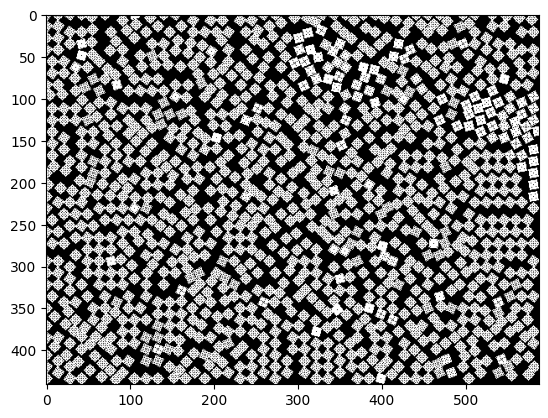

In [30]:
plt.imshow(voronoi_mask_draw)

# Reconstruct Again After Fill

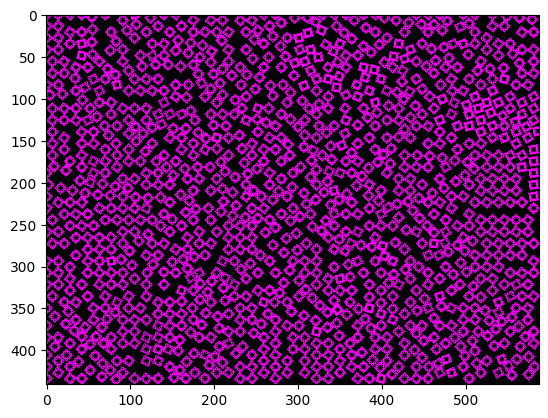

In [31]:
rendered_image = np.zeros_like(mask_draw)

for point_info in tiles_placed_info:
    
    draw_square(
        image=rendered_image,
        center=point_info["point"],
        size=SIZE,
        color=[255, 0, 255],
        border=3,
        theta=point_info["rotation"]
    )
    
plt.imshow(rendered_image)

# Sample Color

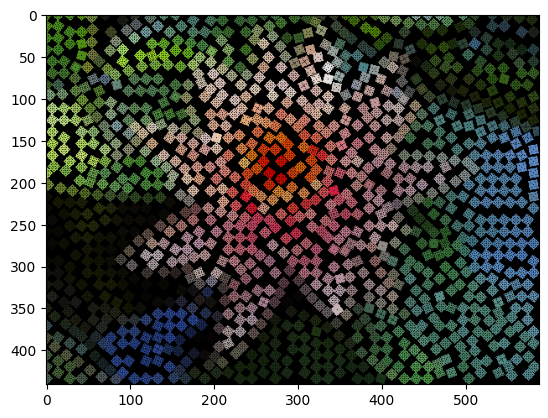

In [32]:
original_array = np.array(downsampled_image)
color_rendered_image = np.zeros_like(original_array)

for point_info in tiles_placed_info:
    coords = get_square_coords(
        center=point_info["point"],
        size=SIZE,
        border=3,
        theta=point_info["rotation"],
        image_shape=original_array.shape[:2]
    )

    sampled_colors = []
    for y, x in coords:
        sampled_colors.append(original_array[y, x])

    if sampled_colors:
        avg_color = np.mean(sampled_colors, axis=0).astype(np.uint8)
    else:
        avg_color = np.array([128, 128, 128], dtype=np.uint8)

    point_info["color"] = avg_color.tolist()

    draw_square(
        image=color_rendered_image,
        center=point_info["point"],
        size=SIZE,
        color=avg_color,
        border=SIZE//2,
        theta=point_info["rotation"]
    )

plt.imshow(color_rendered_image)




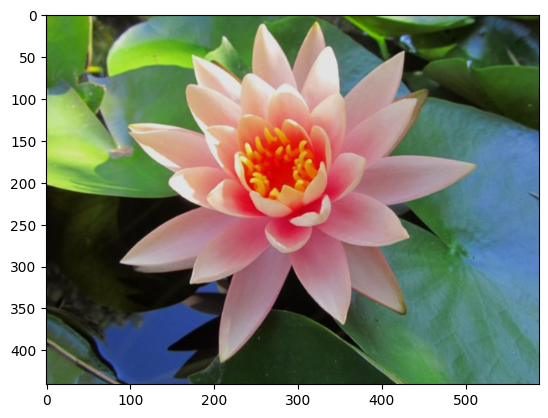

In [33]:
plt.imshow(downsampled_image)

In [34]:
end = datetime.now()
elapsed = end - start
print("Elapsed Time: ", elapsed)

Elapsed Time:  0:02:57.539665


## Create Animation

In [35]:
import imageio

H, W, C = color_rendered_image.shape

n = 20
output_name = "./Results/" + image_path.split("/")[-1][:-4] + "_animation.gif"



background_color = (0,0,0)

# --- Code Logic ---

# Sort tiles by their placement order to ensure correct layering
tiles_placed_info.sort(key=lambda x: x['order'])

frames = []
total_tiles = len(tiles_placed_info)

print(f"Generating GIF with {total_tiles} tiles, adding {n} per frame...")

# Create frames for the animation
for i in range(0, total_tiles, n):
    # Create a new blank canvas for the current frame
    # Using a 3-channel (RGB) image
    frame = np.full((H, W, 3), background_color, dtype=np.uint8)

    # Get the subset of tiles to draw for this frame
    tiles_to_draw = tiles_placed_info[:i + n]

    # Draw each tile onto the frame
    for tile in tiles_to_draw:
        center_point = tuple(map(int, tile['point']))
        rotation_angle = tile['rotation']
        
        # OpenCV uses BGR color format, so we reverse the RGB list
        color_bgr = tile['color'][::-1]

        # Create a RotatedRect object: ((center_x, center_y), (width, height), angle)
        rect = (center_point, (SIZE, SIZE), rotation_angle)

        # Get the 4 vertices of the rotated rectangle
        box_points = cv2.boxPoints(rect)
        box_points = np.intp(box_points) # Convert to integer points

        # Draw the filled rotated square on the frame
        cv2.drawContours(frame, [box_points], 0, color_bgr, -1)
        # Optional: Draw an outline for each tile
        # cv2.drawContours(frame, [box_points], 0, (0,0,0), 1) 

    # Convert the frame from OpenCV's BGR to RGB for imageio
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)

# --- Save the animation ---

if not frames:
    print("No frames were generated. Check if 'tiles_placed_info' is empty.")
else:
    # Add a final frame that pauses at the end for better viewing
    # The 'duration' is in seconds. We make the last frame last for 2 seconds.
    # All other frames will have a default duration.
    durations = [0.1] * (len(frames) - 1) + [2.0]
    
    print(f"Saving animation to '{output_name}'...")
    imageio.mimsave(output_name, frames, duration=durations)
    print("Done!")



Generating GIF with 1170 tiles, adding 20 per frame...
Saving animation to './Results/flower_animation.gif'...
Done!
